# EDA for South African COVID-19 Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from database import model as m
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

secret = {
    "username": "admin",
    "password": "DRgPXv9mLuF0fsplWnox",
    "host": "database-2.cnzbp4ndrpos.eu-west-1.rds.amazonaws.com",
    "port": "1433"
}

engine = create_engine(
    'mssql+pymssql://' +
    secret['username'] + ':' + secret['password'] + '@' + secret['host'] + ':' +
    str(secret['port']) + '/Corona'

)

session = sessionmaker()(bind=engine)

#### Define a function to clean data from Database

In [3]:
def daily(province, con):
    ID_db = pd.read_sql_query("SELECT id FROM Location WHERE location ="+province, con)
    ID_int = ID_db['id'][0]
    ID_str = str(ID_int)
    
    province_db = pd.read_sql_query("SELECT * FROM CasesLocal where location_id = " + ID_str, con)
    province_db['daily difference'] = province_db['confirmed'].diff().fillna(0).astype(np.int) #daily difference
    province_db['confirmed'] = province_db['confirmed'].fillna(0).astype(np.int) #convert confirmed column to int
    
    province_db.rename(columns={'confirmed' : 'cumulative cases'}, inplace=True)
    province_db = province_db.drop(columns=['id','location_id'])
    province_db['log'] = np.log(province_db['cumulative cases'])
    
    return province_db

#### Retrieve Provincial Data

In [4]:
GP = daily("'GP'", engine)
FS = daily("'FS'", engine)
EC = daily("'EC'", engine)
KZN = daily("'KZN'", engine)
WC = daily("'WC'", engine)
LP = daily("'LP'", engine)
NC = daily("'NC'", engine)
MP = daily("'MP'", engine)
NW = daily("'NW'", engine)
SA = daily("'total'", engine)

C:\Users\kopan\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
def bar(n):
    cases = [GP['cumulative cases'][n], WC['cumulative cases'][n], KZN['cumulative cases'][n], FS['cumulative cases'][n], MP['cumulative cases'][n], NW['cumulative cases'][n], LP['cumulative cases'][38], EC['cumulative cases'][n], NC['cumulative cases'][n]]
    provinces = ['GP','WC','KZN','FS','MP','NW','LP','EC','NC']
    prov_df = pd.DataFrame(provinces, columns=["Provinces"])
    cases_df = pd.DataFrame(cases, columns=["Cases"])
    plot_df = prov_df.join(cases_df,lsuffix='Provinces',rsuffix='Cases')
    
    return plot_df

#### Plot Data in a Dashboard format

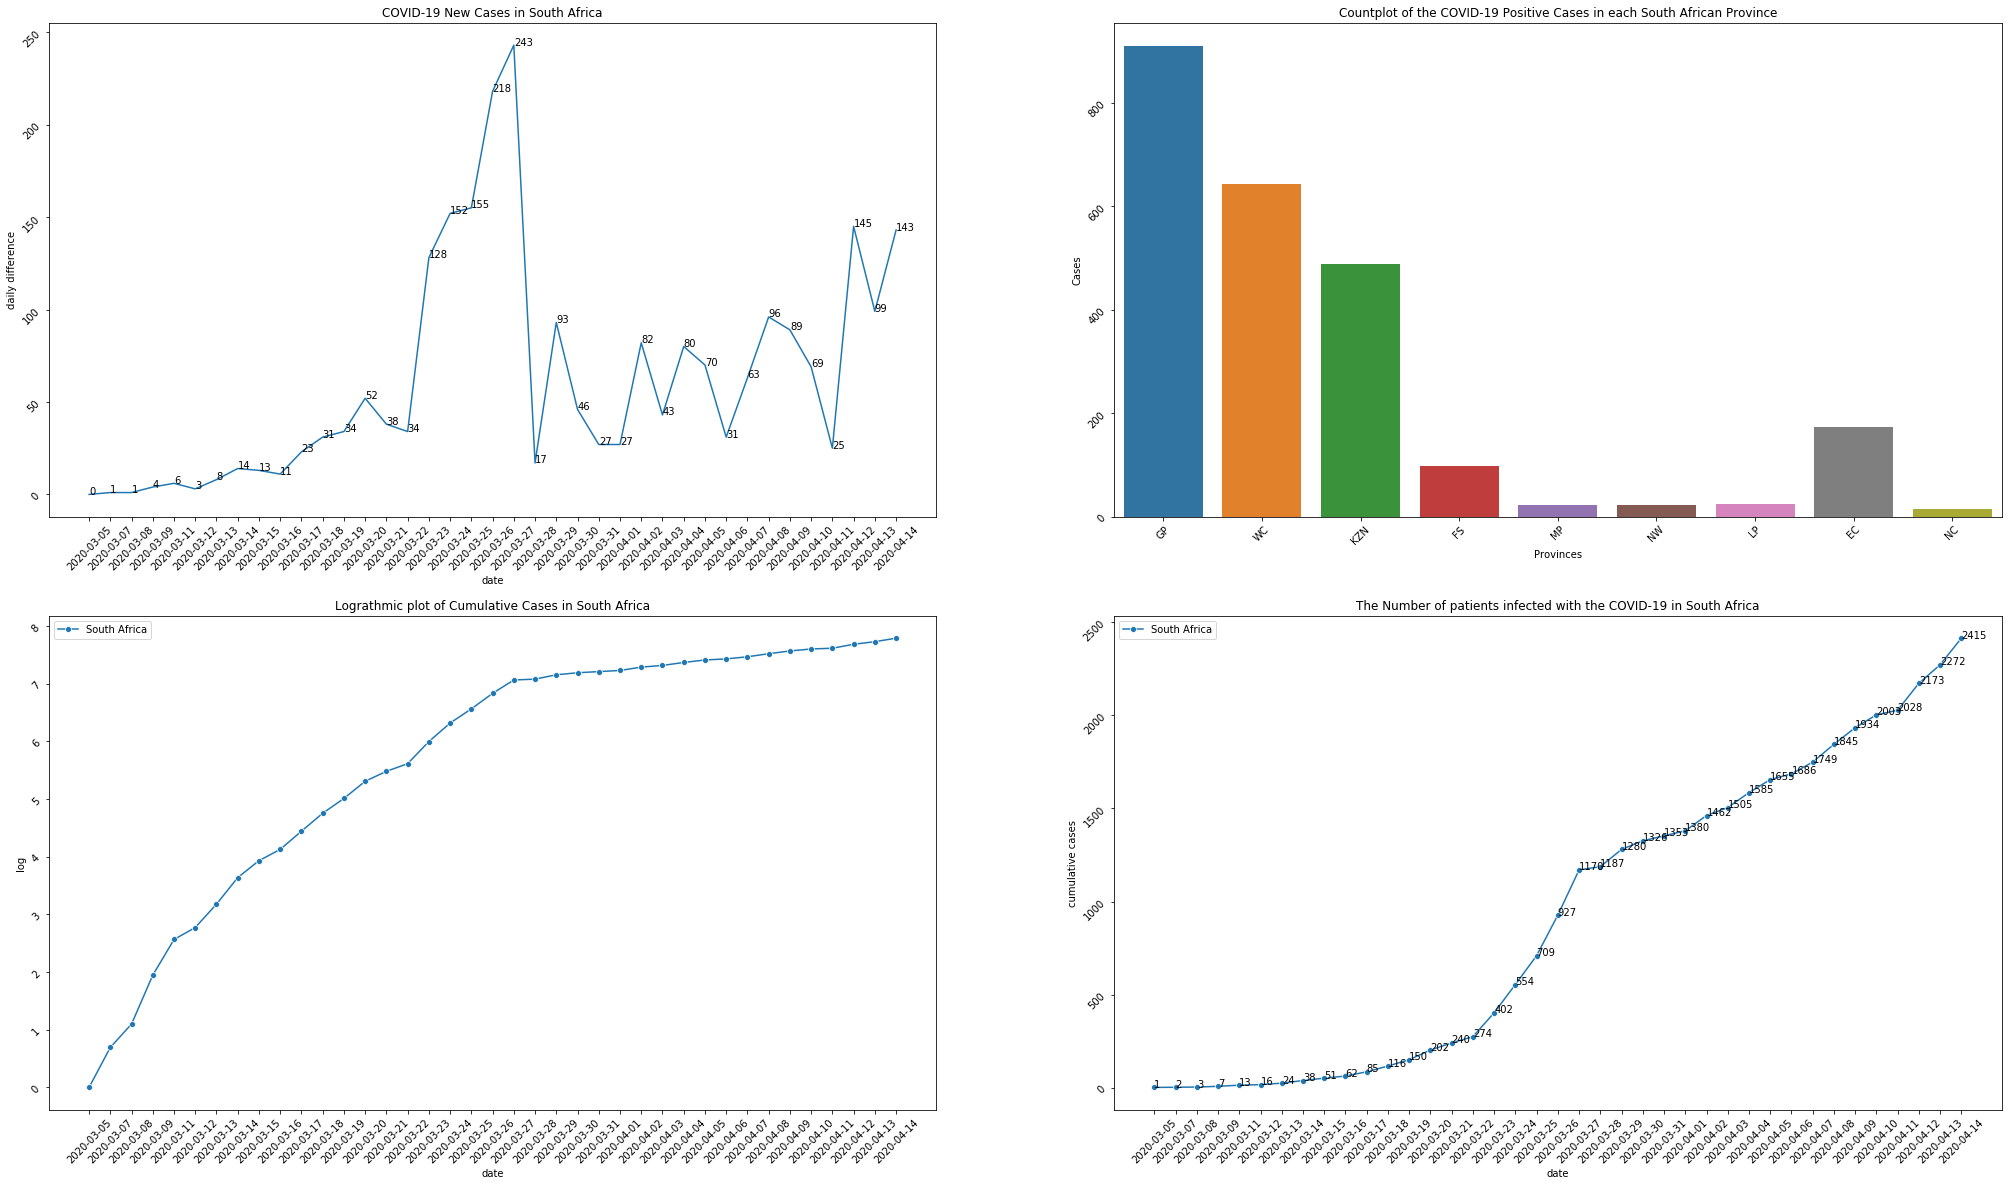

In [9]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(35,20))

sns.lineplot(data=SA[SA['cumulative cases']>0], x='date', y='daily difference', ax=ax[0,0])

for i in SA[SA['cumulative cases']>0].groupby('date'):
    #i[1] is a grouped data frame; looping through each data row in the cumulative dataframe
    for x,y,m in i[1][['date','daily difference','daily difference']].values:  # x = x value; y = y_value ; m = marker value
        ax[0,0].text(x,y,f'{m:.0f}') #ax.text will

ax[0,0].title.set_text('COVID-19 New Cases in South Africa')
ax[0,0].tick_params(labelrotation=45)

bar_df = bar(len(GP)-1)
sns.barplot(x="Provinces", y="Cases", data=bar_df, ax=ax[0,1])

ax[0,1].title.set_text('Countplot of the COVID-19 Positive Cases in each South African Province')
ax[0,1].tick_params(labelrotation=45)

sns.lineplot(data=SA[SA['cumulative cases']>0], x='date', y='log' , label='South Africa', marker='o', 
                  dashes=False,
                  ax=ax[1,0])

ax[1,0].title.set_text('Lograthmic plot of Cumulative Cases in South Africa')
ax[1,0].tick_params(labelrotation=45)

sns.lineplot(data=SA[SA['cumulative cases']>0], x='date', y='cumulative cases' , label='South Africa', marker='o', 
                  dashes=False,
                 ax=ax[1,1])

for i in SA[SA['cumulative cases']>0].groupby('date'):
    #i[1] is a grouped data frame; looping through each data row in the cumulative dataframe
    for x,y,m in i[1][['date','cumulative cases','cumulative cases']].values:  # x = x value; y = y_value ; m = marker value
        ax[1,1].text(x,y,f'{m:.0f}') #ax.text will
ax[1,1].title.set_text('The Number of patients infected with the COVID-19 in South Africa')
ax[1,1].tick_params(labelrotation=45)
